# 1.Mô tả bài toán:
----------------------

- Con người ta hay ở chỗ là "miệng nói 1 mà lòng nghĩ 2", thế mà không chỉ "nói" mà còn cả viết nữa, các nhà thơ, nhà văn đã viết lên những bài văn có tính ngụ ý cao, những lời hay nhưng nghĩa châm biếm, đả kích rất hay.
- Vì thế các tin tức hiện nay, của Donald Trump hay của bất kì celeb nổi tiếng nào cũng làm các con AI của Facebook hay Google đau đầu vì không biết họ có ý như là họ viết dòng twitter đó hay không ???
- Nên có các tập datasets đã được thu thập bởi Kaggle, hay bất kì ai từ 2 nguồn tin cậy cho thứ nhất: tin thật sự,không mỉa mai và hai: tin châm biến mà đến giờ tôi biết là https://www.huffpost.com/ - chuyên tin chính thống và https://www.theonion.com/ - chuyên tin lá cải,châm biếm.
- Và lý do không chọn Twitter làm nguồn cho tập dữ liệu: vì nó có cả 2 loại tin và ngay cả con người cũng khó phân biệt ra 2 loại tin này và ta lại mất thời gian đi gán nhãn dữ liệu. Nhưng cũng có thể test headline trên twitter sau khi đã (cho rằng) train xong model.

[Sarcasm_Detection_on_Facebook](https://www.researchgate.net/publication/327639471_Sarcasm_Detection_on_Facebook_A_Supervised_Learning_Approach)

In [1]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"thuyentrandoan","key":"3d6bc088d4a6d75ad4127e3e082a019c"}'}

Các thủ tục rườm rà nguyên bản để download file:

In [2]:
!pip install kaggle

In [3]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

File rất nhẹ, không gì lo cho việc đường truyền hay nặng google cả, đâu phải máy của mình.

In [4]:
!kaggle datasets download -d rmisra/news-headlines-dataset-for-sarcasm-detection

  0% 0.00/3.30M [00:00<?, ?B/s]
100% 3.30M/3.30M [00:00<00:00, 53.9MB/s]


Ở đây mình dùng luôn unzip trên linux, không cần cài đặt gì cả!

In [5]:
!unzip "/content/news-headlines-dataset-for-sarcasm-detection.zip"

Archive:  /content/news-headlines-dataset-for-sarcasm-detection.zip
  inflating: Sarcasm_Headlines_Dataset.json  
  inflating: Sarcasm_Headlines_Dataset_v2.json  


Để đọc file json, và pandas có hỗ trợ việc đọc này,numpy cũng có nhưng cá nhân mình thích pandas hơn.

In [8]:
import pandas as pd
data_first = pd.read_json("Sarcasm_Headlines_Dataset.json",lines=True)

In [82]:
data_first.head()

,article_link,headline,is_sarcastic
0,https://www.huffingtonpost.com/entry/versace-b...,former versace store clerk sues over secret 'b...,0
1,https://www.huffingtonpost.com/entry/roseanne-...,the 'roseanne' revival catches up to our thorn...,0
2,https://local.theonion.com/mom-starting-to-fea...,mom starting to fear son's web series closest ...,1
3,https://politics.theonion.com/boehner-just-wan...,"boehner just wants wife to listen, not come up...",1
4,https://www.huffingtonpost.com/entry/jk-rowlin...,j.k. rowling wishes snape happy birthday in th...,0


Tương tự đối với file có _v2

In [9]:
data_second = pd.read_json("Sarcasm_Headlines_Dataset_v2.json",lines=True)

In [84]:
data_second.head()

,is_sarcastic,headline,article_link
0,1,thirtysomething scientists unveil doomsday clo...,https://www.theonion.com/thirtysomething-scien...
1,0,dem rep. totally nails why congress is falling...,https://www.huffingtonpost.com/entry/donna-edw...
2,0,eat your veggies: 9 deliciously different recipes,https://www.huffingtonpost.com/entry/eat-your-...
3,1,inclement weather prevents liar from getting t...,https://local.theonion.com/inclement-weather-p...
4,1,mother comes pretty close to using word 'strea...,https://www.theonion.com/mother-comes-pretty-c...


## Tìm hiểu dữ liệu:

Kiểm tra dữ liệu: có missing, skew hay bla bla gì không.

pandas cũng hỗ trợ nốt trong việc tìm missing.

In [85]:
# hàm isna trả về False nếu ko là na:mất thông tin, True : nếu có mất thông tin
# Và False được xem là giá trị 0 còn True được xem là giá trị 1: nên ta tổng theo từng feature/cột
data_first.isna()

,article_link,headline,is_sarcastic
0,False,False,False
1,False,False,False
2,False,False,False
3,False,False,False
4,False,False,False
...,...,...,...
26704,False,False,False
26705,False,False,False
26706,False,False,False
26707,False,False,False


In [15]:
data_first.isna().sum()

article_link    0
headline        0
is_sarcastic    0
dtype: int64

Tương tự trên data_second

In [16]:
data_second.isna().sum()

is_sarcastic    0
headline        0
article_link    0
dtype: int64

pandas hỗ trợ lấy cả index bằng số lẫn nên cột.
- iloc : hỗ trợ lấy bằng số/index.
- loc : hỗ trợ lấy bằng tên cột.

In [17]:
data_first.loc[:,"is_sarcastic"]

0        0
1        0
2        1
3        1
4        0
        ..
26704    0
26705    0
26706    0
26707    0
26708    0
Name: is_sarcastic, Length: 26709, dtype: int64

Hàm value count : đếm giá trị đặc biệt

In [18]:
data_first.loc[:,"is_sarcastic"].value_counts()

0    14985
1    11724
Name: is_sarcastic, dtype: int64

In [19]:
data_second.loc[:,"is_sarcastic"].value_counts()

0    14985
1    13634
Name: is_sarcastic, dtype: int64

seaborn là một thư viện hỗ trợ việc plot dữ liệu như matplotlib.

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


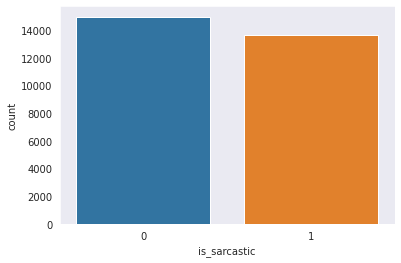

In [20]:
import seaborn as sns
sns.set_style("dark")
sns.countplot(data_second.loc[:,"is_sarcastic"])

Dữ liệu hơi hơi lệch về "không phải châm biếm".

Trong đây ta không cần đường dẫn vì không ai trong đây rảnh mà mở lên đọc cả :)) - thật ra ý chính là mình không cần cột này trong quá trình xử lý,train,eval ... ;v.

In [10]:
data_first.drop(columns= 'article_link' , inplace = True)
data_second.drop(columns= 'article_link', inplace = True)

# 2.Thu nhập data:
----------------------
- Link notebook mình crawl,crawl bằng cơm,rất củ chuối;
  - https://colab.research.google.com/drive/1aRVBtqCGOSvSpfiRK2BQmYIW4suCogWj?authuser=1
- Có dùng tool dataminer : [Data Miner](https://data-miner.io/);
- Có dùng datasets của người khác.

# 3.Xử lý ngôn ngữ tự nhiên - feature engineering:
----------------------

- **NLTK** hay Natural Language Toolkit - Bộ công cụ cho ngôn ngữ tự nhiên - nó là một thư viện được viết bằng Python viết nên để hỗ trợ việc xử lý ngôn ngữ tự nhiên. 
- Với  cách cung cấp các cơ chế và kỹ thuật xử lý ngôn ngữ phổ biến, nó giúp cho việc xử lý ngôn ngữ tự nhiên trở lên dễ dàng và nhanh chóng hơn.
- Lịch sử tí xíu : được viết bởi Steven Bird và Edward Loper, làm việc tại Khoa Máy Tính, Đại Học Pennsylvania, Hoa Kỳ và năm 2001. 
- Và ngoài việc hỗ trợ xử lý ngôn ngữ: 
  - NLTK còn có các mô phỏng đồ hoạ và dữ liệu mẫu hữu ích. 
  - NLTK còn cung cấp các xử lý như classification, tokenization, stemming, tagging, parsing, và semantic reasoning... . 
- Mục đích mà người ta xây dựng bộ **NLTK** (*ngoài việc phục vụ xử lý ngôn ngữ tự nhiên* ) :
  - **NLTK** còn được sử dụng trong Machine Learning với tác dụng làm sạch dữ liệu -**data cleaning**, xử lý dữ liệu đầu vào  **preprocessing** cho các thuật toán Machine Learning.

In [11]:
import nltk
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from wordcloud import WordCloud,STOPWORDS
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize,sent_tokenize
import re,string,unicodedata

Các headlines đang là Tiếng Anh thì mình dùng stopword english.

In [13]:
nltk.download('stopwords')
stop = set(stopwords.words('english'))
punctuation = list(string.punctuation)
stop.update(punctuation)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


**Stop Words là gì ?**
Stop Words là một số từ ngữ, bị các công cụ tìm kiếm bỏ qua một phần hoặc hoàn toàn. Những từ như : “a, a, a, of, or, many,uh ,huh , what ... vv …” chiếm khoảng 25% các bài viết blog trên web. Zậy vừa nhiều mà lại không hề có liên quan gì đến nội dung và ý nghĩa của bài viết. 
Nên các công cụ tìm kiếm như cụ Google mình, trong cả những truy vấn tìm kiếm lẫn trong kết quả đề xuất, thường bỏ qua những Stop Words này.


**Thế thì sao cụ Google lại bỏ qua stopword:**

Vì các **Stop Words** thường gây ra nhiều vấn đề cho các công cụ tìm kiếm như sự mơ hồ, các vấn đề tải máy chủ, v.v… Các từ này cũng làm cản trở các công cụ tìm kiếm cung cấp kết quả tức thì. Nếu những từ này không có liên quan gì đến việc tìm kiếm kết quả, thì có nghĩa là các công cụ tìm kiếm cần bỏ qua các Stop Words từ các truy vấn tìm kiếm và kết quả.

Nói ngắn gọi là : **ngắn gọn**.

[Stop word là gì?](http://seokool.com/google-stop-words-moi-thu-ma-ban-nen-biet/)

In [15]:
stop

{'!',
 '"',
 '#',
 '$',
 '%',
 '&',
 "'",
 '(',
 ')',
 '*',
 '+',
 ',',
 '-',
 '.',
 '/',
 ':',
 ';',
 '<',
 '=',
 '>',
 '?',
 '@',
 '[',
 '\\',
 ']',
 '^',
 '_',
 '`',
 'a',
 'about',
 'above',
 'after',
 'again',
 'against',
 'ain',
 'all',
 'am',
 'an',
 'and',
 'any',
 'are',
 'aren',
 "aren't",
 'as',
 'at',
 'be',
 'because',
 'been',
 'before',
 'being',
 'below',
 'between',
 'both',
 'but',
 'by',
 'can',
 'couldn',
 "couldn't",
 'd',
 'did',
 'didn',
 "didn't",
 'do',
 'does',
 'doesn',
 "doesn't",
 'doing',
 'don',
 "don't",
 'down',
 'during',
 'each',
 'few',
 'for',
 'from',
 'further',
 'had',
 'hadn',
 "hadn't",
 'has',
 'hasn',
 "hasn't",
 'have',
 'haven',
 "haven't",
 'having',
 'he',
 'her',
 'here',
 'hers',
 'herself',
 'him',
 'himself',
 'his',
 'how',
 'i',
 'if',
 'in',
 'into',
 'is',
 'isn',
 "isn't",
 'it',
 "it's",
 'its',
 'itself',
 'just',
 'll',
 'm',
 'ma',
 'me',
 'mightn',
 "mightn't",
 'more',
 'most',
 'mustn',
 "mustn't",
 'my',
 'myself',
 'need

Như đã nói: ta có thể loại đi các từ này mà đảm bảo phần nào không làm ảnh hưởng đến model.

- Link tham khảo stopword Tiếng Việt:
[Stopword cho Tiếng Việt](https://github.com/NguyenVanHieuBlog/vietnamese-stopwords) -chưa dùng lần nào ;v.
- [github.com/stopwords/vietnamese-stopwords](https://github.com/stopwords/vietnamese-stopwords)

Các helper function cho việc clean dữ liệu. Sau này đóng gói, tạo file .py làm lại cho nhanh cũng được.
Trên mạng đó tìm lại cũng được.

In [16]:
from bs4 import BeautifulSoup
def strip_html(text):
    soup = BeautifulSoup(text, "html.parser")
    return soup.get_text()

#Removing the square brackets
def remove_between_square_brackets(text):
    return re.sub('\[[^]]*\]', '', text)
# Removing URL's
def remove_between_square_brackets(text):
    return re.sub(r'http\S+', '', text)
#Removing the stopwords from text
def remove_stopwords(text):
    final_text = []
    for i in text.split():
        if i.strip().lower() not in stop:
            final_text.append(i.strip())
    return " ".join(final_text)
#Removing the noisy text
def denoise_text(text):
    text = strip_html(text)
    text = remove_between_square_brackets(text)
    text = remove_stopwords(text)
    return text

Đối tượng mà ta quăng cho hàm là dạng **Series** nà thao: nà đối tượng là DataFrame nhưng chỉ tính toán ngang hay là **index** (axis=0) **hoặc** là tính toán dọc hay là **columns**  (axis=1).
[Axis trong pandas](https://railsware.com/blog/python-for-machine-learning-pandas-axis-explained/#:~:text=A%20DataFrame%20object%20has%20two,it%20goes%20along%20rows%20direction.)

In [17]:
#pandas hỗ trợ hàm apply
data_first['headline']=data_first['headline'].apply(denoise_text)
#Tương tự
data_second['headline']=data_second['headline'].apply(denoise_text)

In [18]:
data_first.head(3)

,headline,is_sarcastic
0,former versace store clerk sues secret 'black ...,0
1,'roseanne' revival catches thorny political mo...,0
2,mom starting fear son's web series closest thi...,1


In [19]:
full_data = pd.concat((data_first,data_second))

In [20]:
full_data.head()

,headline,is_sarcastic
0,former versace store clerk sues secret 'black ...,0
1,'roseanne' revival catches thorny political mo...,0
2,mom starting fear son's web series closest thi...,1
3,"boehner wants wife listen, come alternative de...",1
4,j.k. rowling wishes snape happy birthday magic...,0


Tinh chỉnh để tí cho model học

In [21]:
words = []
for i in full_data.headline.values:
    l = []
    for j in i.split():
        l.extend(i.split())
        break
    words.append(l)   

WORDCLOUD cho các từ xuất hiện trong headline có tính châm biếm : is_sarcastic = 1

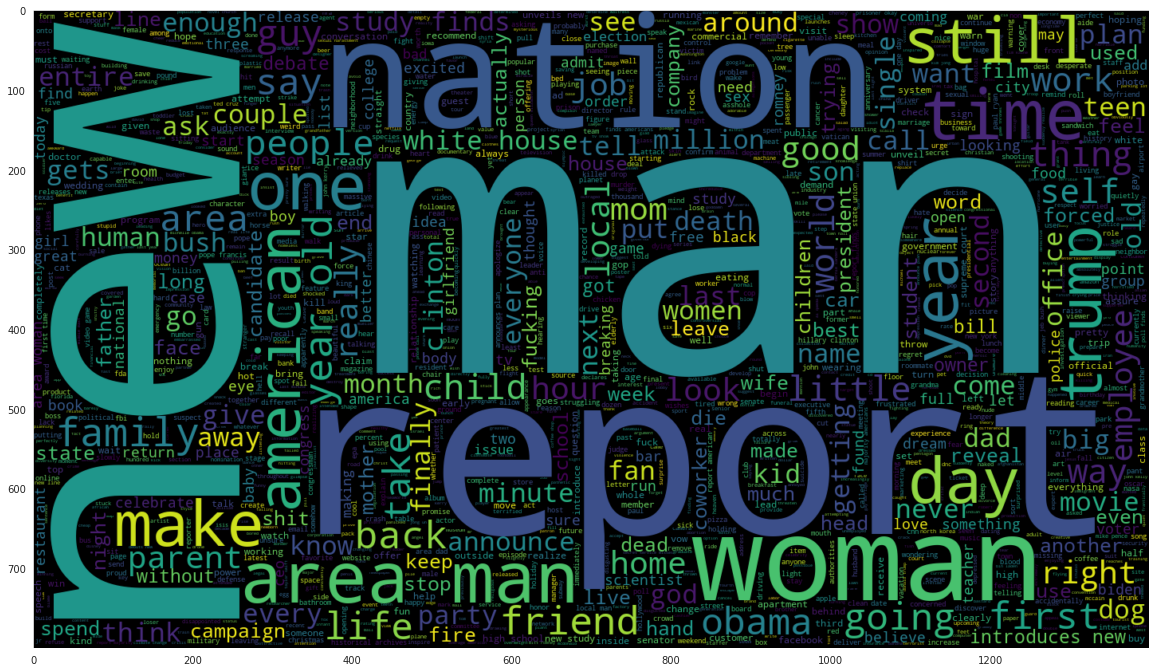

In [32]:
# Copy trên kaggle muốn chạy cho nó fan-sì:
import matplotlib.pyplot as plt
plt.figure(figsize = (20,20)) # Text that is Sarcastic
wc = WordCloud(max_words = 2000 , width = 1400 , height = 800).generate(" ".join(data_first[data_first.is_sarcastic == 1].headline))
plt.imshow(wc , interpolation = 'bilinear')

Đừng chạy lại vì nó xử lý rất lâu.

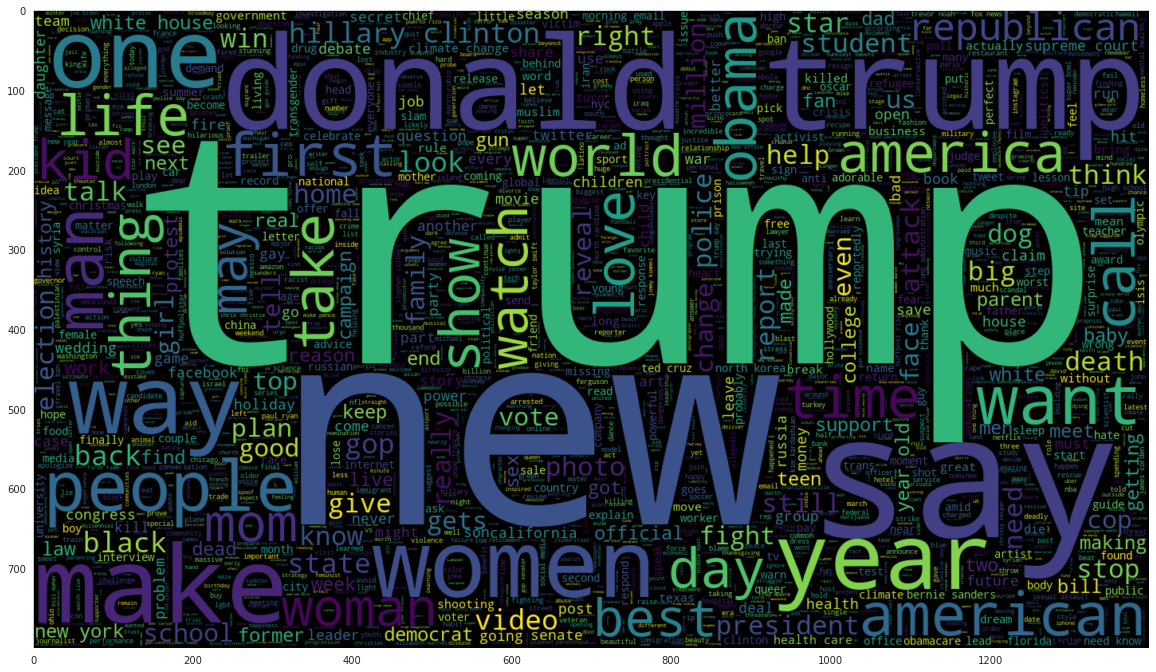

In [33]:
plt.figure(figsize = (20,20)) # Text that is Sarcastic
wc = WordCloud(max_words = 2000 , width = 1400 , height = 800).generate(" ".join(data_first[data_first.is_sarcastic == 0].headline))
plt.imshow(wc , interpolation = 'bilinear')

# 4.Chọn model, học và fine tuning:
----------------------

# TRAINING WORD2VEC MODEL:

## Giới thiệu về WORD2VEC:

Word2vec is a two-layer neural net that processes text by “vectorizing” words. Its input is a text corpus and its output is a set of vectors: feature vectors that represent words in that corpus. While Word2vec is not a deep neural network, it turns text into a numerical form that deep neural networks can understand.

**Word2vec** là sự kết hợp giữa 2 mạng nơron **Skip-Gram** và **CBOW** - kết quả là  **Word2vec** cũng là một mạng nơron:

![alt text](https://nguyentruonglong.net/images/GeneralCBOW.png)

**CBOW** Model: Nôm na là phương pháp đem chỉ 1 từ làm input và đoán ngữ cảnh của từ đó - hay nói cách khác là có thể các từ nào xuất hiện kèm với từ đó.
- Ví dụ : cho cụm từ "Have a great day".
Ta cần dự đoán từ nào sẽ xuất hiện nếu cho qua một model được mà ta thiết kế chỉ một từ duy nhất **great**; Đầu ra ta muốn ở đây là từ **day** vì **great day** sẽ có ý nghĩa hơn **great a** hay **great Have**.
- Cụ thể hơn là ta biến đổi one-hot-encoding/one-hot-vector fit trên câu "Have a great day" rồi tương ứng được vector của **great** sẽ là [0 0 1 0] và đưa qua mạng nơron gì gì đó để nó học lại đầu ra qua softmax và cuối cùng là dự đoán bằng softmax sao cho mạng được huấn luyện sẽ ngày cần giá trị [0 0 0 1] nhất. đại khái là thế.

Còn model **Skip-Gram** là model ngược lại so với CBOW:
![alt text](https://miro.medium.com/max/1400/0*Ta3qx5CQsrJloyCA.png)

Xử lý dữ liệu:

In [22]:
import gensim
from keras.preprocessing import text, sequence

#Dimension of vectors we are generating
EMBEDDING_DIM = 200
MAXLEN = 150

#Creating Word Vectors by Word2Vec Method (takes time...)
w2v_model = gensim.models.Word2Vec(sentences = words , size=EMBEDDING_DIM , window = 5 , min_count = 1)

tokenizer = text.Tokenizer(num_words=35000)
tokenizer.fit_on_texts(words)
tokenized_train = tokenizer.texts_to_sequences(words)
x = sequence.pad_sequences(tokenized_train, maxlen = MAXLEN)

Using TensorFlow backend.


In [23]:
# Adding 1 because of reserved 0 index
# Embedding Layer creates one more vector for "UNKNOWN" words, or padded words (0s). This Vector is filled with zeros.
# Thus our vocab size inceeases by 1
vocab_size = len(tokenizer.word_index) + 1

In [24]:
# Function to create weight matrix from word2vec gensim model
def get_weight_matrix(model, vocab):
    # total vocabulary size plus 0 for unknown words
    vocab_size = len(vocab) + 1
    # define weight matrix dimensions with all 0
    weight_matrix = np.zeros((vocab_size, EMBEDDING_DIM))
    # step vocab, store vectors using the Tokenizer's integer mapping
    for word, i in vocab.items():
        weight_matrix[i] = model[word]
    return weight_matrix

In [25]:
import numpy as np
#Getting embedding vectors from word2vec and usings it as weights of non-trainable keras embedding layer
embedding_vectors = get_weight_matrix(w2v_model, tokenizer.word_index)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  if __name__ == '__main__':


In [28]:
embedding_vectors[1].shape

(200,)

Biến đối tất cả thành từng vector với chiều ngang = EMBEDDING_DIM = 200

In [101]:
embedding_vectors.shape

(38072, 200)

In [29]:
import keras
from keras.models import Sequential
from keras.layers import Dense,Embedding,LSTM,Dropout,Bidirectional,Activation, Flatten, Bidirectional, GlobalMaxPool1D

In [30]:
#Defining Neural Network
model = Sequential()
#Non-trainable embeddidng layer
model.add(Embedding(input_dim = vocab_size, output_dim=EMBEDDING_DIM, weights=[embedding_vectors], input_length=MAXLEN, trainable=True))
#LSTM 
model.add(Bidirectional(LSTM(units=128 , recurrent_dropout = 0.3 , dropout = 0.5)))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer=keras.optimizers.Adam(lr = 0.01), loss='binary_crossentropy', metrics=['acc'])

In [104]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 150, 200)          7614400   
_________________________________________________________________
bidirectional_1 (Bidirection (None, 256)               336896    
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 257       
Total params: 7,951,553
Trainable params: 7,951,553
Non-trainable params: 0
_________________________________________________________________


In [31]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x, full_data.is_sarcastic , test_size = 0.3 , random_state = 0) 

Tại sao lại dùng BATCH_SIZE = 64, cứ dùng đi, nhưng mà chọn BATCH_SIZE thường là theo công thức 2^n vì nó phù hợp với cách bố trị dữ liệu trên bộ nhớ, mặc khác việc chọn BATCH_SIZE thường là 64 128 256 vì nếu nhỏ thì chạy rất lâu, tại sao lâu tại vì nó quá trình BACK_PROP lại diễn ra nhiều lần. 

In [32]:
BATCH_SIZE = 64
EPOCHS = 5
history = model.fit(x_train, y_train, batch_size = BATCH_SIZE , validation_data = (x_test,y_test) , epochs = EPOCHS)

/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/indexed_slices.py:434: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 38729 samples, validate on 16599 samples
Epoch 1/5
38729/38729 [==============================] - 694s 18ms/step - loss: 0.3830 - acc: 0.8211 - val_loss: 0.2383 - val_acc: 0.9022
Epoch 2/5
38729/38729 [==============================] - 685s 18ms/step - loss: 0.0888 - acc: 0.9680 - val_loss: 0.2232 - val_acc: 0.9263
Epoch 3/5
38729/38729 [==============================] - 682s 18ms/step - loss: 0.0275 - acc: 0.9904 - val_loss: 0.2982 - val_acc: 0.9320
Epoch 4/5
38729/38729 [==============================] - 680s 18ms/step - loss: 0.0140 - acc: 0.9951 - val_loss: 0.3366 - val_acc: 0.9322
Epoch 5/5
38729/38729 [==============================] - 685s 18ms/step - loss: 0.0078 - acc: 0.9974 - val_loss: 0.4146 - val_acc: 0.9318


In [46]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


Lưu những thứ đã lớn và đã train nãy giờ:
- model config my_model_new: json;
- model weights;
- embedding vector cho model trên.

In [64]:
from keras.models import load_model
from keras.models import model_from_json
model.save('/content/drive/My Drive/Sarcasm Detection/my_model_new.h5')
model.save_weights("/content/drive/My Drive/Sarcasm Detection/my_model_new.h5")

In [68]:
model_json = model.to_json()
with open("/content/drive/My Drive/Sarcasm Detection/my_model_new.json", "w") as json_file:
    json_file.write(model_json)

In [72]:
np.save("/content/drive/My Drive/Sarcasm Detection/embedding_vectors_new_model",embedding_vectors)

In [33]:
epochs = [i for i in range(EPOCHS)]
fig , ax = plt.subplots(1,2)
train_acc = history.history['acc']
train_loss = history.history['loss']
val_acc = history.history['val_acc']
val_loss = history.history['val_loss']
fig.set_size_inches(20,10)

ax[0].plot(epochs , train_acc , 'go-' , label = 'Training Accuracy')
ax[0].plot(epochs , val_acc , 'ro-' , label = 'Testing Accuracy')
ax[0].set_title('Training & Testing Accuracy')
ax[0].legend()
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Accuracy")

ax[1].plot(epochs , train_loss , 'go-' , label = 'Training Loss')
ax[1].plot(epochs , val_loss , 'ro-' , label = 'Testing Loss')
ax[1].set_title('Training & Testing Loss')
ax[1].legend()
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Loss")
plt.show()

NameError: ignored

In [66]:
y_pred = model.predict_classes(x_test)
print(y_pred[:5],y_test[:5])

[[1]
 [1]
 [0]
 [0]
 [1]] 2180     1
2566     1
20252    0
10988    0
17200    1
Name: is_sarcastic, dtype: int64


Giải thích loss:
- Binary CrossEntropy: Là một hàm để đánh giá độ lỗi phổ biến cho việc phân lớp nhị phân không chỉ cho Neural Network (mà có thể apply vào các model máy học bình thường khác ... nhưng chưa thử, nhưng chắc chắn vậy vì để đánh giá mô hình thì ta có thể dùng bất kì hàm lỗi nào cũng được).
- ![alt text](https://miro.medium.com/max/1096/1*rdBw0E-My8Gu3f_BOB6GMA.png)
- Ví dụ: ở công thức trên: y=1 là cho châm biếm, còn y=0 là cho không châm biếm.

Thay đổi với model trước : tăng số lượng neuron bị drop cho cả recurrent.

## Fine tuning:

- Biến đổi recurrent_dropout = 0.4 , dropout = 0.5.
- Thêm một lớp fully-connected 32 nơron để trích xuất lại vector đặc trưng tốt hơn. 
- Nói về tuing BATCH_SIZE:
 - Tốc độ tính toán : nghĩa là mỗi lần/**iteration**: nó lấy 128(nếu mình đặt Batch size = 128) mẫu dữ liệu qua để train, tính toán lỗi,(tính trung bình...) rồi update lại weight trong quá trình back prop;
 - Thế cũng ảnh hưởn đến tốc độ hội tụ của của thuật toán vì chia batch nhỏ thì nhiều lần iteration quá làm cho (tính toán luôn cả thời gian học lại @@) quá lâu.

[Batch Size](https://stats.stackexchange.com/questions/153531/what-is-batch-size-in-neural-network)

Chút trích dẫn:
**It has been observed in practice that when using a larger batch there is a significant degradation in the quality of the model, as measured by its ability to generalize.**

- Nôm na: ... thường thì batch càng lớn có sự giảm trong chất lượng model ...

### Thử lại lần 2 với: 
- Thêm một lớp LSTM 64 nút;
- Thêm một lớp Dense - Fully conntected 32 nút.

In [36]:
#Defining Neural Network
model_2 = Sequential()
#Non-trainable embeddidng layer
model_2.add(Embedding(input_dim = vocab_size, output_dim=EMBEDDING_DIM, weights=[embedding_vectors], input_length=150, trainable=True))
#LSTM 
model_2.add(Bidirectional(LSTM(units=64,return_sequences=True)))
model_2.add(Bidirectional(LSTM(units=64 , recurrent_dropout = 0.4 , dropout = 0.5)))
model_2.add(Dense(32,activation='relu'))
model_2.add(Dense(1, activation='sigmoid'))
model_2.compile(optimizer=keras.optimizers.Adam(lr = 0.01), loss='binary_crossentropy', metrics=['acc'])

model_2.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 150, 200)          7614400   
_________________________________________________________________
bidirectional_4 (Bidirection (None, 150, 128)          135680    
_________________________________________________________________
bidirectional_5 (Bidirection (None, 128)               98816     
_________________________________________________________________
dense_4 (Dense)              (None, 32)                4128      
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 33        
Total params: 7,853,057
Trainable params: 7,853,057
Non-trainable params: 0
_________________________________________________________________


In [37]:
# Tăng batch_size
BATCH_SIZE = 128
EPOCHS = 5
history = model_2.fit(x_train, y_train, batch_size = BATCH_SIZE , validation_data = (x_test,y_test) , epochs = EPOCHS)

/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/indexed_slices.py:434: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 38729 samples, validate on 16599 samples
Epoch 1/5
38729/38729 [==============================] - 480s 12ms/step - loss: 0.4375 - acc: 0.7837 - val_loss: 0.2606 - val_acc: 0.9004
Epoch 2/5
38729/38729 [==============================] - 475s 12ms/step - loss: 0.1130 - acc: 0.9618 - val_loss: 0.2216 - val_acc: 0.9226
Epoch 3/5
38729/38729 [==============================] - 475s 12ms/step - loss: 0.0387 - acc: 0.9872 - val_loss: 0.2817 - val_acc: 0.9284
Epoch 4/5
38729/38729 [==============================] - 472s 12ms/step - loss: 0.0200 - acc: 0.9938 - val_loss: 0.3472 - val_acc: 0.9307
Epoch 5/5
38729/38729 [==============================] - 472s 12ms/step - loss: 0.0143 - acc: 0.9956 - val_loss: 0.3766 - val_acc: 0.9313


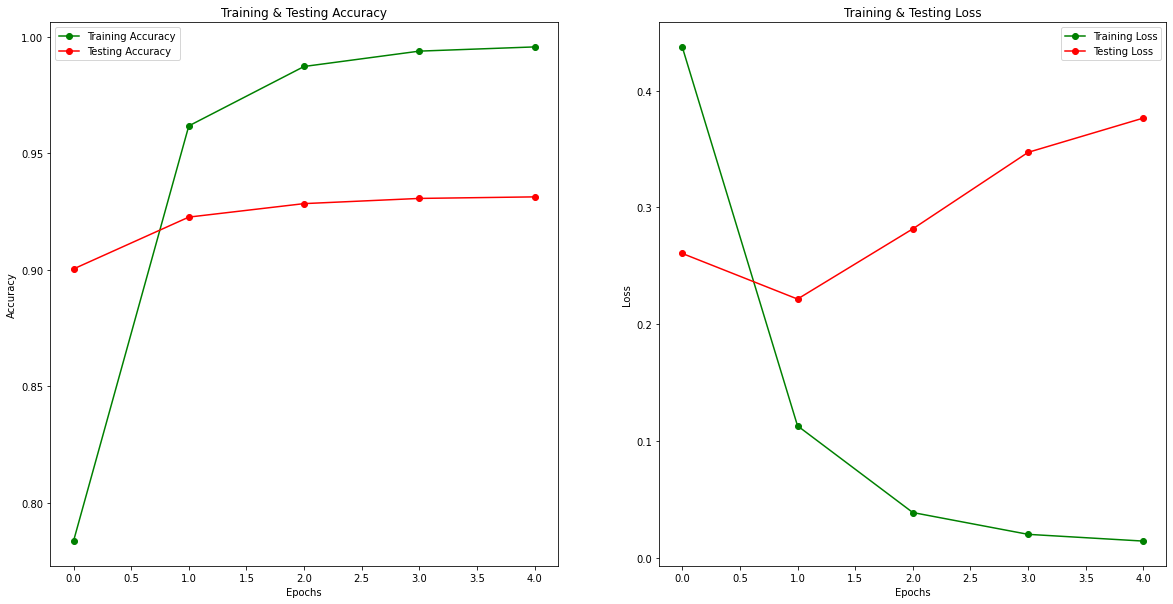

In [39]:
import matplotlib.pyplot as plt

epochs = [i for i in range(EPOCHS)]
fig , ax = plt.subplots(1,2)
train_acc = history.history['acc']
train_loss = history.history['loss']
val_acc = history.history['val_acc']
val_loss = history.history['val_loss']
fig.set_size_inches(20,10)

ax[0].plot(epochs , train_acc , 'go-' , label = 'Training Accuracy')
ax[0].plot(epochs , val_acc , 'ro-' , label = 'Testing Accuracy')
ax[0].set_title('Training & Testing Accuracy')
ax[0].legend()
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Accuracy")

ax[1].plot(epochs , train_loss , 'go-' , label = 'Training Loss')
ax[1].plot(epochs , val_loss , 'ro-' , label = 'Testing Loss')
ax[1].set_title('Training & Testing Loss')
ax[1].legend()
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Loss")
plt.show()

Nhận xét: cũng không khá hơn gì so với model đầu.Vậy thử predict kết quả như thế nào.

In [40]:
y_pred = model_2.predict_classes(x_test)

In [41]:
from sklearn.metrics import confusion_matrix

In [42]:
confusion_matrix(y_pred,y_test)

array([[8404,  526],
       [ 614, 7055]])

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


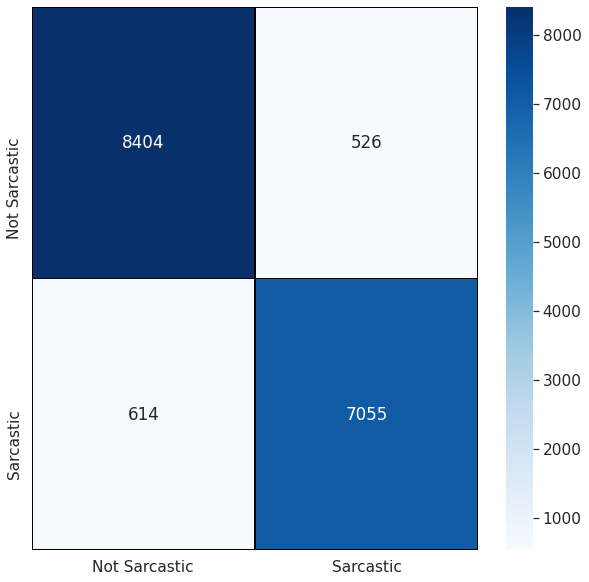

In [43]:
import seaborn as sns
sns.set(font_scale=1.4)
col_ind_names = ['Not Sarcastic','Sarcastic']
cm = pd.DataFrame(confusion_matrix(y_pred,y_test) , index = col_ind_names , columns = col_ind_names)
plt.figure(figsize = (10,10))
sns.heatmap(cm,cmap= "Blues", linecolor = 'black' , linewidth = 1 , 
            annot = True, fmt='' , xticklabels = col_ind_names , yticklabels =col_ind_names)

In [45]:
print(classification_report(y_test, y_pred, target_names=col_ind_names))

               precision    recall  f1-score   support

Not Sarcastic       0.94      0.93      0.94      9018
    Sarcastic       0.92      0.93      0.93      7581

     accuracy                           0.93     16599
    macro avg       0.93      0.93      0.93     16599
 weighted avg       0.93      0.93      0.93     16599



In [49]:
new_unseen_data = pd.read_csv("/content/drive/My Drive/full_data.csv")
new_unseen_data["headline"] = new_unseen_data["headline"].apply(denoise_text)
words_new = []
for i in new_unseen_data.headline.values:
    l = []
    for j in i.split():
        l.extend(i.split())
        break
    words_new.append(l)   

tokenized_train = tokenizer.texts_to_sequences(words_new)
x = sequence.pad_sequences(tokenized_train, maxlen = MAXLEN)

In [50]:
y_pred =  model_2.predict_classes(x)

In [52]:
y_test = new_unseen_data["is_sarcastic"]

In [53]:
print(classification_report(y_test, y_pred, target_names=col_ind_names))

               precision    recall  f1-score   support

Not Sarcastic       0.71      0.74      0.73      1156
    Sarcastic       0.69      0.66      0.67      1003

     accuracy                           0.70      2159
    macro avg       0.70      0.70      0.70      2159
 weighted avg       0.70      0.70      0.70      2159



Thử đến đây kết quả tốt hơn model đầu,em lưu nó lại - vì sao nó tốt hơn : có thể là do lớp LTSM thứ 2 học lại một vài đặc trưng dù nhỏ nhưng có xuất hiện trong dataset chưa từng thấy,nên nó kết quả vừa cao trên data train/val : pre và recall đều hơn 90% và vừa thử nghiệm trên tập dữ liệu này cũng tương đối cao!

### Thử lại lần 3 với: 
- Thêm một lớp LSTM 64 nút;
- Thêm một lớp Dense - Fully conntected 32 nút.
- Batch_size = 64

In [90]:
import gensim
import numpy as np
from keras.preprocessing import text, sequence

In [ ]:
#Dimension of vectors we are generating
EMBEDDING_DIM = 200
#Creating Word Vectors by Word2Vec Method (takes time...)
w2v_model = gensim.models.Word2Vec(sentences = words , size=EMBEDDING_DIM , window = 5 , min_count = 1)

In [ ]:
MAXLEN = 100
tokenizer = text.Tokenizer(num_words=35000)
tokenizer.fit_on_texts(words)
tokenized_train = tokenizer.texts_to_sequences(words)
x = sequence.pad_sequences(tokenized_train, maxlen = MAXLEN)

#Getting embedding vectors from word2vec and usings it as weights of non-trainable keras embedding layer
embedding_vectors = get_weight_matrix(w2v_model, tokenizer.word_index)

In [ ]:
#Defining Neural Network
model_3 = Sequential()
#Non-trainable embeddidng layer
model_3.add(Embedding(input_dim = vocab_size, output_dim=EMBEDDING_DIM, weights=[embedding_vectors], input_length=MAXLEN, trainable=True))
#LSTM 
model_3.add(Bidirectional(LSTM(units=64,recurrent_dropout = 0.3 , dropout = 0.5,return_sequences=True)))
model_3.add(Bidirectional(LSTM(units=64 , recurrent_dropout = 0.4 , dropout = 0.5)))
model_3.add(Dense(64,activation='relu'))
model_3.add(Dense(1, activation='sigmoid'))
model_3.compile(optimizer=keras.optimizers.Adam(lr = 0.01), loss='binary_crossentropy', metrics=['acc'])

model_3.summary()

In [ ]:
# batch_size = 64 
# Sau khi đã tăng số chiều của x từ 20 lên 100
x_train, x_test, y_train, y_test = train_test_split(x, data_first.is_sarcastic , test_size = 0.3 , random_state = 0) 
BATCH_SIZE = 64
EPOCHS = 5
history = model_3.fit(x_train, y_train, batch_size = BATCH_SIZE , validation_data = (x_test,y_test) , epochs = EPOCHS)

In [ ]:
MAXLEN = 100
tokenizer = text.Tokenizer(num_words=35000)
tokenizer.fit_on_texts(words)
# tokenized_train = tokenizer.texts_to_sequences(words)
# x = sequence.pad_sequences(tokenized_train, maxlen = MAXLEN)

# #Getting embedding vectors from word2vec and usings it as weights of non-trainable keras embedding layer
# embedding_vectors = get_weight_matrix(w2v_model, tokenizer.word_index)

In [ ]:
tokenized_train_2 = tokenizer.texts_to_sequences(word)
x_2 = sequence.pad_sequences(tokenized_train_2, maxlen = MAXLEN)

In [ ]:
y_2 = data_second.is_sarcastic

In [ ]:
y_pred = model_3.predict_classes(x_2)

In [ ]:
print(classification_report(y_2, y_pred, target_names=col_ind_names))

               precision    recall  f1-score   support

Not Sarcastic       0.91      0.94      0.93     14985
    Sarcastic       0.93      0.90      0.92     13634

     accuracy                           0.92     28619
    macro avg       0.92      0.92      0.92     28619
 weighted avg       0.92      0.92      0.92     28619



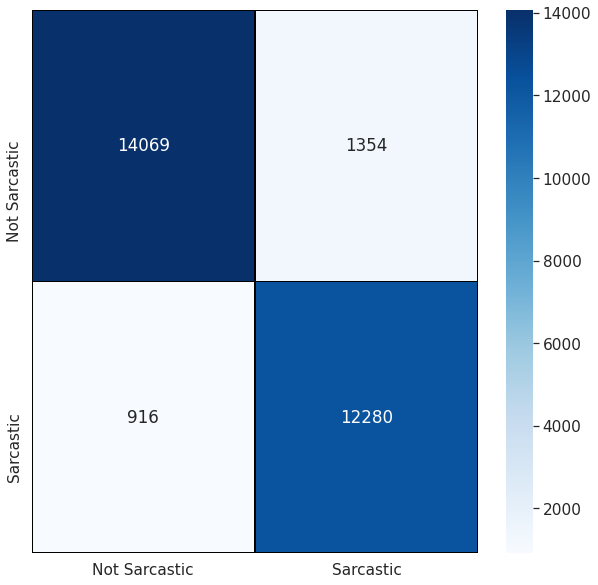

In [ ]:
import seaborn as sns
sns.set(font_scale=1.4)
col_ind_names = ['Not Sarcastic','Sarcastic']
cm = pd.DataFrame(confusion_matrix(y_pred,y_2) , index = col_ind_names , columns = col_ind_names)
plt.figure(figsize = (10,10))
sns.heatmap(cm,cmap= "Blues", linecolor = 'black' , linewidth = 1 , 
            annot = True, fmt='' , xticklabels = col_ind_names , yticklabels =col_ind_names)

In [ ]:
words2 = []
for i in data_second.headline.values:
    l = []
    for j in i.split():
        l.extend(i.split())
        break
    words2.append(l)   
for i in words:
  words2.append(i)

In [ ]:
len(words2)

55328

In [ ]:
MAXLEN = 50
EMBEDDING_DIM = 200

tokenizer = text.Tokenizer(num_words=35000)
tokenizer.fit_on_texts(words2)
tokenized_train = tokenizer.texts_to_sequences(words2)
x = sequence.pad_sequences(tokenized_train, maxlen = MAXLEN)

w2v_model = gensim.models.Word2Vec(sentences = words2 , size=EMBEDDING_DIM , window = 5 , min_count = 1)

vocab_size = len(tokenizer.word_index) + 1
# #Getting embedding vectors from word2vec and usings it as weights of non-trainable keras embedding layer
embedding_vectors = get_weight_matrix(w2v_model, tokenizer.word_index)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  if __name__ == '__main__':


In [ ]:
#Defining Neural Network
model_4 = Sequential()
#Non-trainable embeddidng layer
model_4.add(Embedding(input_dim = vocab_size, output_dim=EMBEDDING_DIM, weights=[embedding_vectors], input_length=MAXLEN, trainable=True))
#LSTM 
model_4.add(Bidirectional(LSTM(units=128,recurrent_dropout = 0.4 , dropout = 0.4)))
model_4.add(Dense(64,activation='relu'))
model_4.add(Dense(1, activation='sigmoid'))
model_4.compile(optimizer=keras.optimizers.Adam(lr = 0.01), loss='binary_crossentropy', metrics=['acc'])

model_4.summary()

Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_12 (Embedding)     (None, 50, 200)           7614400   
_________________________________________________________________
bidirectional_18 (Bidirectio (None, 256)               336896    
_________________________________________________________________
dense_16 (Dense)             (None, 64)                16448     
_________________________________________________________________
dense_17 (Dense)             (None, 1)                 65        
Total params: 7,967,809
Trainable params: 7,967,809
Non-trainable params: 0
_________________________________________________________________


In [ ]:
is_sarcastic_dat = np.hstack((data_first.is_sarcastic,data_second.is_sarcastic))

In [ ]:
is_sarcastic_dat.shape,x.shape

((55328,), (55328, 50))

In [ ]:
# batch_size = 128 
# Sau khi đã tăng số chiều của x từ 20 lên 50
x_train, x_test, y_train, y_test = train_test_split(x, is_sarcastic_dat , test_size = 0.3 , random_state = 0) 
BATCH_SIZE = 128
EPOCHS = 5
history = model_4.fit(x_train, y_train, batch_size = BATCH_SIZE , validation_data = (x_test,y_test) , epochs = EPOCHS)

/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/indexed_slices.py:434: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 38729 samples, validate on 16599 samples
Epoch 1/5
38729/38729 [==============================] - 201s 5ms/step - loss: 0.6923 - acc: 0.5362 - val_loss: 0.6894 - val_acc: 0.5433
Epoch 2/5
38729/38729 [==============================] - 196s 5ms/step - loss: 0.6886 - acc: 0.5481 - val_loss: 0.6902 - val_acc: 0.5408
Epoch 3/5
38729/38729 [==============================] - 198s 5ms/step - loss: 0.6616 - acc: 0.6052 - val_loss: 0.7248 - val_acc: 0.5247
Epoch 4/5
38729/38729 [==============================] - 201s 5ms/step - loss: 0.6233 - acc: 0.6432 - val_loss: 0.7900 - val_acc: 0.5126
Epoch 5/5
38729/38729 [==============================] - 197s 5ms/step - loss: 0.5679 - acc: 0.6952 - val_loss: 0.8603 - val_acc: 0.5153


Fine tune quá dở: acc nhỏ mà val acc cũng nhỏ nốt: bỏ mô hình, train lại.

Ở đây thử dropout = 0.5

In [ ]:
#Defining Neural Network
model_5 = Sequential()
#Non-trainable embeddidng layer
model_5.add(Embedding(input_dim = vocab_size, output_dim=EMBEDDING_DIM, weights=[embedding_vectors], input_length=MAXLEN, trainable=True))
#LSTM 
model_5.add(Bidirectional(LSTM(units=128,recurrent_dropout = 0.3 , dropout = 0.5 ,return_sequences = True)))
model_5.add(GlobalMaxPool1D())
model_5.add(Dense(64,activation='relu'))
model_5.add(Dense(32,activation='relu'))
model_5.add(Dense(1, activation='sigmoid'))
model_5.compile(optimizer=keras.optimizers.Adam(lr = 0.01), loss='binary_crossentropy', metrics=['acc'])

model_5.summary()

x_train, x_test, y_train, y_test = train_test_split(x, is_sarcastic_dat , test_size = 0.2 , random_state = 0) 
BATCH_SIZE = 128
EPOCHS = 5
history = model_5.fit(x_train, y_train, batch_size = BATCH_SIZE , validation_data = (x_test,y_test) , epochs = EPOCHS)

Model: "sequential_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_14 (Embedding)     (None, 50, 200)           7614400   
_________________________________________________________________
bidirectional_20 (Bidirectio (None, 50, 256)           336896    
_________________________________________________________________
global_max_pooling1d_2 (Glob (None, 256)               0         
_________________________________________________________________
dense_18 (Dense)             (None, 64)                16448     
_________________________________________________________________
dense_19 (Dense)             (None, 32)                2080      
_________________________________________________________________
dense_20 (Dense)             (None, 1)                 33        
Total params: 7,969,857
Trainable params: 7,969,857
Non-trainable params: 0
___________________________________________

/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/indexed_slices.py:434: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 44262 samples, validate on 11066 samples
Epoch 1/5
44262/44262 [==============================] - 225s 5ms/step - loss: 0.6910 - acc: 0.5398 - val_loss: 0.6891 - val_acc: 0.5451
Epoch 2/5
44262/44262 [==============================] - 221s 5ms/step - loss: 0.6807 - acc: 0.5652 - val_loss: 0.6939 - val_acc: 0.5354
Epoch 3/5
44262/44262 [==============================] - 226s 5ms/step - loss: 0.6138 - acc: 0.6539 - val_loss: 0.7786 - val_acc: 0.5246
Epoch 4/5
44262/44262 [==============================] - 221s 5ms/step - loss: 0.5347 - acc: 0.7011 - val_loss: 1.1937 - val_acc: 0.5043
Epoch 5/5
15744/44262 [=========>....................] - ETA: 2:16 - loss: 0.4615 - acc: 0.7356

KeyboardInterrupt: ignored

WORD2VEC là một trong những kĩ thuật WORDEMBEDDING nghĩa rằng nó tìm mối quan hệ về mặt ngữ nghĩa (text semantic) theo một độ đo nào đó sẽ được trình bày sau:

- Ví dụ cặp từ Queen và King sẽ có mối quan hệ gần nhau hơn cặp từ Boy và Girl hay 2 địa danh chẳng hạn : Paris-Hanoi.

Phương pháp này tối ưu hơn One-hot Encoding ở chỗ: One-hot Encoding chỉ có nước cháy nhà-cháy cpu vì chiều của vector encoding đó cực lớn khi đang xét về ngữ cảnh là 1 văn bản.

In [ ]:
data_first = pd.read_json("Sarcasm_Headlines_Dataset.json",lines=True)
data_second = pd.read_json("Sarcasm_Headlines_Dataset_v2.json",lines=True)

In [ ]:
data_first.drop(columns="article_link",inplace = True)
data_second.drop(columns="article_link",inplace = True)

In [ ]:
df = pd.concat((data_first,data_second))

In [ ]:
df['headline']=df['headline'].apply(denoise_text)

In [ ]:
words = []
for i in df.headline.values:
    l = []
    for j in i.split():
        l.extend(i.split())
        break
    words.append(l)   

In [ ]:
from gensim.models import Word2Vec

In [ ]:
# MAXLEN = 50
# EMBEDDING_DIM = 200

# tokenizer = text.Tokenizer(num_words=35000)
# tokenizer.fit_on_texts(words2)
# tokenized_train = tokenizer.texts_to_sequences(words2)
# x = sequence.pad_sequences(tokenized_train, maxlen = MAXLEN)

w2v_model = Word2Vec(sentences = words , size=EMBEDDING_DIM , window = 5 , min_count = 1)


In [ ]:
vocab_size = len(tokenizer.word_index) + 1
print(vocab_size)

38072


In [ ]:
# #Getting embedding vectors from word2vec and usings it as weights of non-trainable keras embedding layer
embedding_vectors = get_weight_matrix(w2v_model, tokenizer.word_index)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  if __name__ == '__main__':


In [ ]:
#Defining Neural Network
model_5 = Sequential()
#Non-trainable embeddidng layer
model_5.add(Embedding(input_dim = vocab_size, output_dim=EMBEDDING_DIM, weights=[embedding_vectors], input_length=maxlen, trainable=True))
#LSTM 
model_5.add(Bidirectional(LSTM(units=128,recurrent_dropout = 0.3 , dropout = 0.5 ,return_sequences = True)))
model_5.add(GlobalMaxPool1D())
model_5.add(Dense(64,activation='relu'))
model_5.add(Dense(32,activation='relu'))
model_5.add(Dense(1, activation='sigmoid'))
model_5.compile(optimizer=keras.optimizers.Adam(lr = 0.01), loss='binary_crossentropy', metrics=['acc'])

model_5.summary()

x_train, x_test, y_train, y_test = train_test_split(X, y , test_size = 0.2 , random_state = 0) 
BATCH_SIZE = 128
EPOCHS = 5
history = model_5.fit(x_train, y_train, batch_size = BATCH_SIZE , validation_data = (x_test,y_test) , epochs = EPOCHS)

Model: "sequential_19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_19 (Embedding)     (None, 100, 200)          7614400   
_________________________________________________________________
bidirectional_24 (Bidirectio (None, 100, 256)          336896    
_________________________________________________________________
global_max_pooling1d_6 (Glob (None, 256)               0         
_________________________________________________________________
dense_30 (Dense)             (None, 64)                16448     
_________________________________________________________________
dense_31 (Dense)             (None, 32)                2080      
_________________________________________________________________
dense_32 (Dense)             (None, 1)                 33        
Total params: 7,969,857
Trainable params: 7,969,857
Non-trainable params: 0
___________________________________________

/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/indexed_slices.py:434: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 44262 samples, validate on 11066 samples
Epoch 1/5
 2048/44262 [>.............................] - ETA: 6:40 - loss: 0.7080 - acc: 0.5483

KeyboardInterrupt: ignored

Chạy lâu quá nên bỏ tiếp:

In [ ]:
#Defining Neural Network
model_6 = Sequential()
#Non-trainable embeddidng layer
model_6.add(Embedding(input_dim = vocab_size, output_dim=EMBEDDING_DIM, weights=[embedding_vectors], input_length=100, trainable=True))
#LSTM 
model_6.add(Bidirectional(LSTM(units=128,recurrent_dropout = 0.3 , dropout = 0.5 ,return_sequences = True)))
model_6.add(GlobalMaxPool1D())
model_6.add(Dense(64,activation='relu'))
model_6.add(Dense(32,activation='relu'))
model_6.add(Dense(1, activation='sigmoid'))
model_6.compile(optimizer=keras.optimizers.Adam(lr = 0.01), loss='binary_crossentropy', metrics=['acc'])

model_6.summary()

x_train, x_test, y_train, y_test = train_test_split(X, y , test_size = 0.2 , random_state = 0) 
BATCH_SIZE = 128
EPOCHS = 5
history = model_6.fit(x_train, y_train, batch_size = BATCH_SIZE , validation_data = (x_test,y_test) , epochs = EPOCHS)

Model: "sequential_25"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_25 (Embedding)     (None, 100, 200)          7614400   
_________________________________________________________________
bidirectional_29 (Bidirectio (None, 100, 256)          336896    
_________________________________________________________________
global_max_pooling1d_11 (Glo (None, 256)               0         
_________________________________________________________________
dense_45 (Dense)             (None, 64)                16448     
_________________________________________________________________
dense_46 (Dense)             (None, 32)                2080      
_________________________________________________________________
dense_47 (Dense)             (None, 1)                 33        
Total params: 7,969,857
Trainable params: 7,969,857
Non-trainable params: 0
___________________________________________

/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/indexed_slices.py:434: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 44262 samples, validate on 11066 samples
Epoch 1/5
44262/44262 [==============================] - 410s 9ms/step - loss: 0.4081 - acc: 0.8065 - val_loss: 0.3253 - val_acc: 0.8626
Epoch 2/5
44262/44262 [==============================] - 409s 9ms/step - loss: 0.2046 - acc: 0.9195 - val_loss: 0.2586 - val_acc: 0.9010
Epoch 3/5
44262/44262 [==============================] - 407s 9ms/step - loss: 0.1187 - acc: 0.9558 - val_loss: 0.2846 - val_acc: 0.9184
Epoch 4/5
44262/44262 [==============================] - 412s 9ms/step - loss: 0.0868 - acc: 0.9686 - val_loss: 0.2753 - val_acc: 0.9252
Epoch 5/5
44262/44262 [==============================] - 414s 9ms/step - loss: 0.0648 - acc: 0.9759 - val_loss: 0.2890 - val_acc: 0.9300


Ồ cao: lưu lại model!

In [ ]:
from keras.models import load_model
from keras.models import model_from_json
model_6.save('/content/drive/My Drive/Sarcasm Detection/my_model6.h5')
model_6.save_weights("/content/drive/My Drive/Sarcasm Detection/model_6_weights.h5")

In [ ]:
model_json = model_6.to_json()
with open("/content/drive/My Drive/Sarcasm Detection/model_6_js.json", "w") as json_file:
    json_file.write(model_json)

# 5.Dùng model đã train để tạo chương trình:

In [ ]:
# np.save("/content/drive/My Drive/Sarcasm Detection/embedding_vectors_model_6",embedding_vectors)

In [61]:
from keras.models import model_from_json
json_file = open("/content/drive/My Drive/Sarcasm Detection/model_js.json", 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
loaded_model.load_weights("/content/drive/My Drive/Sarcasm Detection/model_weights.h5")
loaded_model.summary()

Model: "sequential_16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_16 (Embedding)     (None, 50, 200)           7614400   
_________________________________________________________________
bidirectional_22 (Bidirectio (None, 50, 256)           336896    
_________________________________________________________________
global_max_pooling1d_4 (Glob (None, 256)               0         
_________________________________________________________________
dense_24 (Dense)             (None, 64)                16448     
_________________________________________________________________
dense_25 (Dense)             (None, 32)                2080      
_________________________________________________________________
dense_26 (Dense)             (None, 1)                 33        
Total params: 7,969,857
Trainable params: 7,969,857
Non-trainable params: 0
___________________________________________

In [5]:
from numpy import load
# load array
embedding_vectors_2 = load("/content/drive/My Drive/Sarcasm Detection/embedding_vectors.npy")

Load tokenizer

In [6]:
import gensim
import numpy as np
from keras.preprocessing import text, sequence
import pickle
import pandas as pd

In [7]:
with open('/content/drive/My Drive/Sarcasm Detection/tokenizer_model_6.pickle', 'rb') as handle:
    tokenizer = pickle.load(handle)

In [8]:
new_unseen_data = pd.read_csv("/content/drive/My Drive/full_data.csv")

# 6.Đối chiếu performance của model trên dataset đã cho và trên 2000 headine mới.

In [10]:
import nltk
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from wordcloud import WordCloud,STOPWORDS
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize,sent_tokenize
import re,string,unicodedata
nltk.download('stopwords')
stop = set(stopwords.words('english'))
punctuation = list(string.punctuation)
stop.update(punctuation)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [11]:
from bs4 import BeautifulSoup

def strip_html(text):
    soup = BeautifulSoup(text, "html.parser")
    return soup.get_text()

#Removing the square brackets
def remove_between_square_brackets(text):
    return re.sub('\[[^]]*\]', '', text)
# Removing URL's
def remove_between_square_brackets(text):
    return re.sub(r'http\S+', '', text)
#Removing the stopwords from text
def remove_stopwords(text):
    final_text = []
    for i in text.split():
        if i.strip().lower() not in stop:
            final_text.append(i.strip())
    return " ".join(final_text)
#Removing the noisy text
def denoise_text(text):
    text = strip_html(text)
    text = remove_between_square_brackets(text)
    text = remove_stopwords(text)
    return text

In [12]:
new_unseen_data["headline"] = new_unseen_data["headline"].apply(denoise_text)

In [51]:
words_new = []
for i in new_unseen_data.headline.values:
    l = []
    for j in i.split():
        l.extend(i.split())
        break
    words_new.append(l)   

In [52]:
from keras.models import model_from_json
json_file = open("/content/drive/My Drive/Sarcasm Detection/my_model_new.json", 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
loaded_model.load_weights("/content/drive/My Drive/Sarcasm Detection/my_model_new.h5")
loaded_model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 150, 200)          7614400   
_________________________________________________________________
bidirectional_2 (Bidirection (None, 256)               336896    
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 257       
Total params: 7,951,553
Trainable params: 7,951,553
Non-trainable params: 0
_________________________________________________________________


In [62]:
MAXLEN = 50
tokenized_train = tokenizer.texts_to_sequences(words_new)
x = sequence.pad_sequences(tokenized_train, maxlen = MAXLEN)

In [57]:
MAXLEN = 50
tokenizer = text.Tokenizer(num_words=35000)
tokenizer.fit_on_texts(words_new)
tokenized_train = tokenizer.texts_to_sequences(words_new)
x = sequence.pad_sequences(tokenized_train, maxlen = MAXLEN)

In [67]:
y_pred = loaded_model.predict_classes(x)

In [64]:
y_test = new_unseen_data["is_sarcastic"].values.reshape(2159,1)

In [66]:
from sklearn.metrics import classification_report

In [69]:
print(classification_report(y_true= y_test, y_pred = y_pred))

              precision    recall  f1-score   support

           0       0.57      0.58      0.58      1156
           1       0.51      0.49      0.50      1003

    accuracy                           0.54      2159
   macro avg       0.54      0.54      0.54      2159
weighted avg       0.54      0.54      0.54      2159



--------------------
**Kết luận**

Lý do mà độ precision , và recal cho cả 2 nhãn đều thấp đến mức này là do: chưa từng thấy từ trong từ điển nên khi gặp từ mới này bộ Tokenizer đã lưu tokenize như thế nào nên dẫn đến kết quả thấp như vậy - và lý do của việc chưa từng thấy từ này trong từ điển có thể là do datasets Sarcasm này chưa được cập nhập lại đối với headlines được crawl tại thời điểm hiện tại.

# !!! Scipt for save:

In [56]:
from keras.models import load_model
from keras.models import model_from_json
import pickle
# save model
model_2.save('/content/drive/My Drive/Sarcasm Detection/model_2/model_2.h5')
# save weights
model_2.save_weights("/content/drive/My Drive/Sarcasm Detection/model_2/your_model_weights.h5")
# save embedding vectors
np.save("/content/drive/My Drive/Sarcasm Detection/model_2/your_embedding_vectors",embedding_vectors)
# save
with open('/content/drive/My Drive/Sarcasm Detection/model_2/your_tokenizer.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

# !!! Scipt for download drive file:

In [ ]:
	auth.authenticate_user()
	gauth = GoogleAuth()
	gauth.credentials = GoogleCredentials.get_application_default()
	drive = GoogleDrive(gauth)
	file_id = "YOUR_FILE_ID"
	# For example: "1-sltCi9nCSQmA-xaBPutq6Yfl6YONC_H" id of Tokenizer file
	downloaded = drive.CreateFile({'id': file_id})
	downloaded.GetContentFile(os.path.join(data_dir, 'file_name.zip'))